In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy import integrate
from scipy import linalg
from scipy import interpolate
from scipy.signal import lfilter
from math import cos

from numba import jit

import PyQt5
from Classes import CrankNicolson, Hamiltonian, EMField,WaveFunction
from Functions import Math, GroundState

from IPython.display import clear_output
import dill
%matplotlib notebook

#PMatrix=np.load("../data/PMatrix_8cycle.npy")
#aArray=np.load("../data/aArray_8cycle.npy")

<h3> Definición de los parámetros

In [5]:
Nx = 1000 #Número de puntos en el mallado espacial
Nt = 5000 #Número de puntos en el mallado temporal
x,h = np.linspace(-100,100,Nx,retstep=True) 
a = 1.0 #Paramentro que define el ancho de la función gaussiana
#p0 = 0.0 
x0 = 0.0  #Centro de la función gaussiana a tiempo 0
tmax = 110*8
t,dt = np.linspace(0,tmax,Nt,retstep=True) #Mallado temporal equiespaciado

H = Hamiltonian.H(x,Nx,h,t,VBool=False, ABool=False,softening=1.0) 

WF = WaveFunction.WF(a,(x,h),(t,dt),H)
psi = WF.psi

<h3> Máscara de absorción

In [3]:
def Mask(x,xb,gamma):
    mask = np.ones(len(x),dtype='float')
    for i in range(len(x)):
        if x[i]<(x[0]+xb):
            mask[i] = np.power(np.cos(np.pi*x[i]*gamma/(2*xb)),1/8)
        if x[i]>(x[-1]-xb):
            mask[i] = np.power(np.cos(np.pi*x[i]*gamma/(2*xb)),1/8)
    return mask

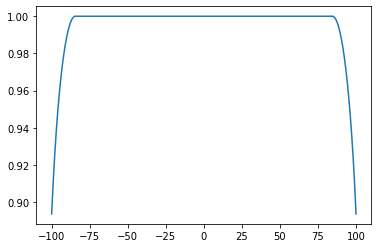

In [4]:
fig = plt.figure();
ax = fig.add_subplot(111); #linear axis

mask = np.nan_to_num(Mask(x,15,0.71))
ax.plot(WF.x,mask)
WF.mask =mask

<h3> Representación de la de la densidad de probabiliad de la
onda de partida 

/home/rmhsik/Software/TFG/venv/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


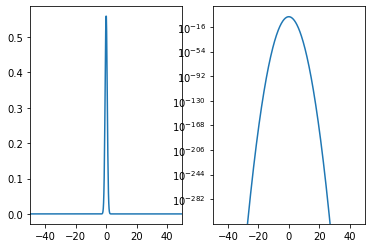

In [5]:
P = WF.P() #Densidad de probabilidad

fig = plt.figure();
axli = fig.add_subplot(121); #linear axis
axlo = fig.add_subplot(122); #logarithmic axis

axli.set_xlim(-50,50)
axlo.set_xlim(-50,50)

axli.plot(WF.x,P);
axlo.plot(WF.x,P);
axlo.set_yscale('log')
plt.show()

<h3> Evolución de la función de onda en ausencia de potencial y campo eléctrico

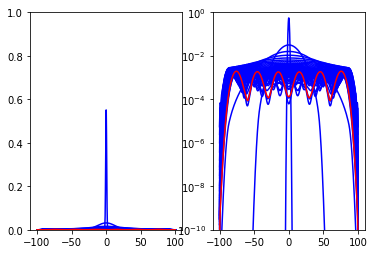

CPU times: user 7min 12s, sys: 4min 3s, total: 11min 15s
Wall time: 2min 52s


In [6]:
%%time 

fig = plt.figure();
axli = fig.add_subplot(121);
axlo = fig.add_subplot(122);
axli.set_ylim(0,1.0)
axlo.set_ylim(1E-10,1.0)


#Creamos el Hamiltoniano. En este caso desactivamos la opción del
#potencial Coulombiano y del potencial vector.
H = Hamiltonian.H(x,Nx,h,t,VBool=False, ABool=False,softening=1.0) 

#Creamos el propagador con los parámetros deseados
Prop = CrankNicolson.Propagator(H,Nx,dt)

#En este caso partimos de la función de onda sin normalizar 
#para que sea más visual
WF.psi = WF.WaveFunction()

for i in range(len(t)): #Se resolverá la propagación para cada instante de tiempo
    
    #Como se trata de un Hamiltoniano constante en el tiempo
    #no hará falta ejecutar Update() en cada iteración, tanto
    #en el Hamiltoniano como en el propagador
    
    WF.psi = Prop.Propagate(WF.psi) #Propaga de psi0 a psi1 un dt
    WF.psi= WF.psi*WF.mask
    if (i%100 == 0): #Representaremos unicamente las iteraciones multiplos de 100
        axli.plot(x,WF.P(),'b');
        axlo.plot(x,WF.P(),'b');
    #psi0 = psi1 #Movemos la función para la próxima iteración

axli.plot(x,WF.P(),'r'); #Representamos el estado final (lineal)
axlo.plot(x,WF.P(),'r'); #Representamos el estado final (logarítmico)
axlo.set_yscale('log')

plt.show()

<h3>Cálculo del estado fundamental del Hamiltoniano Coulombiano empleando propagación en tiempo imaginario

<h5> Ajuste del parámetro de softening

In [7]:
%%time 

def f(ep):
    return ep+0.5

delta = 1E-5

epdelta = 1E-5
sa = 1.90
sb = 2.10

eps = 1.

psi = WF.WaveFunction()

while (eps > epdelta): #Secant method
    H = Hamiltonian.H(x,Nx,h,t,VBool=True, ABool=False,softening=sa)
    Prop = CrankNicolson.Propagator(H,Nx,dt)
    epa = GroundState.GroundState(H,Prop,psi,x,delta)[1]

    H = Hamiltonian.H(x,Nx,h,t,VBool=True, ABool=False,softening=sb)
    Prop = CrankNicolson.Propagator(H,Nx,dt)
    epb = GroundState.GroundState(H,Prop,psi,x,delta)[1]
                                    
    sc = sb-(f(epb))*(sb-sa)/(f(epb)-f(epa))
    
    H = Hamiltonian.H(x,Nx,h,t,VBool=True, ABool=False,softening=sc)
    Prop = CrankNicolson.Propagator(H,Nx,dt)
    epc = GroundState.GroundState(H,Prop,psi,x,delta)[1]
    
    eps = abs(abs(epc)-0.5)
    sa = sb
    sb = sc
                                    
print("epc: "+str(epc))
print("sc: " +str(sc))
print("eps: " + str(eps))

epc: (-0.49999998975533283+0j)
sc: (2.0369083358430484+0j)
eps: 1.024466717014505e-08
CPU times: user 5min 41s, sys: 2min 57s, total: 8min 38s
Wall time: 2min 12s


<h5> Cálculo del estado fundamental

Energy: (-0.5010703141668347+0j)
Softening Parameter: (2.0369083358430484+0j)
Error: 0.21406283336693477
CPU times: user 1min 1s, sys: 30.6 s, total: 1min 32s
Wall time: 23.8 s


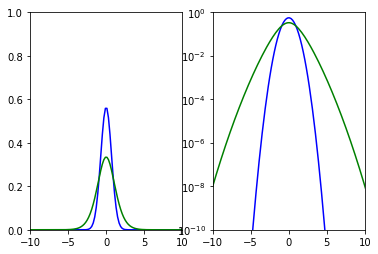

In [8]:
%%time

fig = plt.figure();
axli = fig.add_subplot(121);
axlo = fig.add_subplot(122);
axli.set_ylim(0,1.0)
axlo.set_ylim(1E-10,1.0)
axli.set_xlim(-10,10)
axlo.set_xlim(-10,10)

psi = WF.WaveFunction()
psiG,ep = GroundState.GroundState(H,Prop,psi,x,1E-6)
WF.psi = psiG
WF.H = H
axli.plot(x,np.conjugate(psi)*psi,'b')
axli.plot(x,WF.P(),'g')
axlo.plot(x,np.conjugate(psi)*psi,'b')
axlo.plot(x,WF.P(),'g')
axlo.set_yscale('log')

print("Energy: "+str(WF.Energy()))
print("Softening Parameter: " +str(H.soft))
print("Error: " + str(abs(abs(WF.Energy())-0.5)/0.5*100))

<h3>Propagación con el potencial Coulombiano y con campo 
    eléctrico

In [9]:
%%time

#fig = plt.figure();
#ax = fig.add_subplot(111);
#ax.set_xlim(-50,50)
#ax.set_ylim(0,1.0)

#Redefinimos el mallado temporal para este caso
#t,dt = np.linspace(0,120,Nt,retstep=True) 
#Redifinimos el mallado espacial para aumentarlo
#x,h = np.linspace(-100,100,Nx,retstep=True) 
#Recalculamos la función Gaussiana
WF.psi = psiG

#Creamos un array donde se almacenará la densida de probabilidad
PMatrix = np.zeros((Nt,Nx))
aArray = np.zeros(Nt)

#Volvemos a crear tanto el Hamiltoniano como el propagador.
#Los datos del campo EM estan definidos internamente en la clase
#del Hamiltoniano
H = Hamiltonian.H(x,Nx,h,t,VBool=True, ABool = True,softening=sc,tmax=tmax)
WF.H = H
Prop = CrankNicolson.Propagator(H,Nx,dt)

psi0 = psiG #De nuevo partimos de la función de onda sin nomarlizar

for i in range(len(t)):
    H.Update(i) #Actualizamos el Hamiltoniano a la itreación i-ésima
    Prop.Update(H) #Actualizamos el porpagador con el nuevo Hamiltoniano
    PMatrix[i] = np.array(WF.P())
    aArray[i] = WF.aExpected()
    WF.psi = WF.mask*Prop.Propagate(WF.psi)  
    
    #if (i%100== 0): #Rpresentamos solamente los multiplos de 100
    #    ax.plot(x,np.conjugate(psi1)*psi1,'b')
    
    #psi0 = psi1 #Preparamos para la siguiente iteración

#ax.plot(x,np.conjugate(psi1)*psi1,'r'); #Representamos el estado final

Calculando el potencial vector...
potencial vector calculado!


/home/rmhsik/Software/TFG/venv/lib/python3.7/site-packages/ipykernel_launcher.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
/home/rmhsik/Software/TFG/venv/lib/python3.7/site-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part


CPU times: user 9min 12s, sys: 4min 44s, total: 13min 57s
Wall time: 3min 42s


<IPython.core.display.Javascript object>


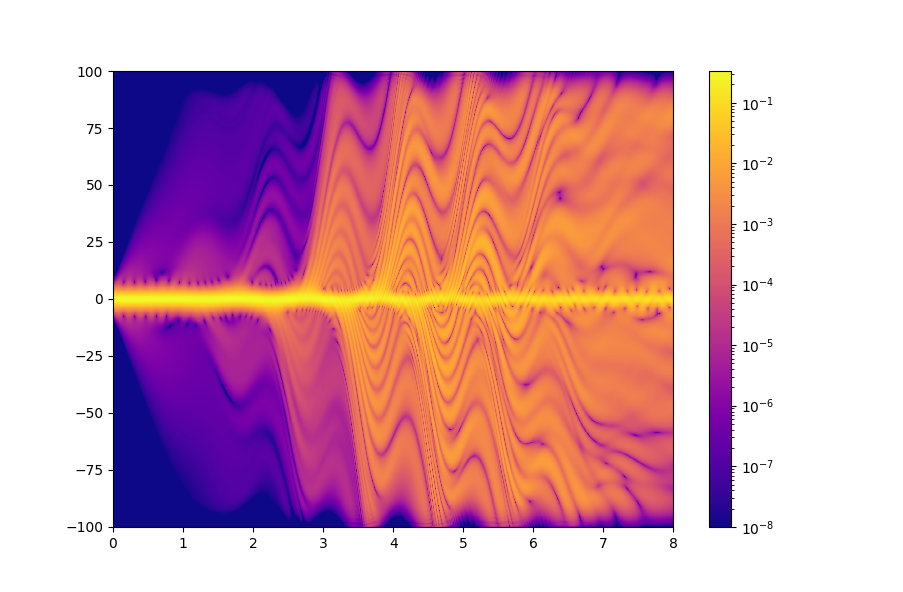

In [7]:
fig = plt.figure();
ax = fig.add_subplot(111);
c = ax.pcolormesh(t/110,x,np.transpose(PMatrix),cmap='plasma',norm=colors.LogNorm(vmin=1E-8,vmax=PMatrix.max()))
fig.colorbar(c, ax=ax)
#ax.plot(t/110,H.A)
#ax.set_yscale('log')
#ax.set_ylim(-10,10)
plt.show()

<IPython.core.display.Javascript object>


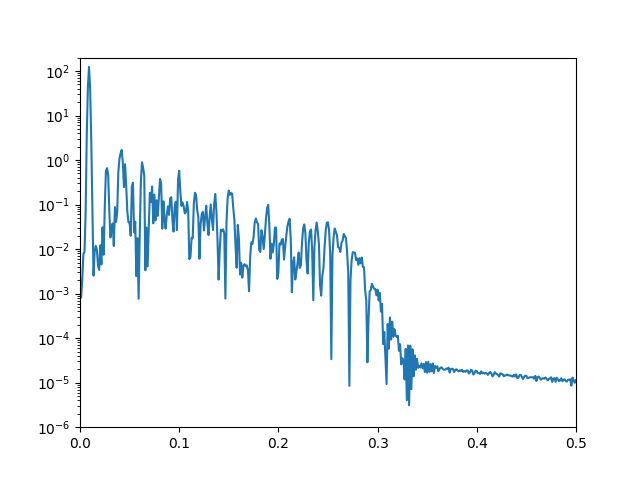

/home/rmhsik/Software/TFG/venv/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [6]:
fig = plt.figure();
ax = fig.add_subplot(111);
#ax.set_xlim(0,)

fourier = np.fft.fft(aArray)
Y = np.conjugate(fourier)*fourier
freq = np.fft.fftfreq(len(fourier),dt)
ax.set_xlim(0,0.5)
ax.set_ylim(1e-6,2e2)
ax.plot(freq,Y)
ax.set_yscale('log')
#ax.set_xscale('log')

In [22]:
np.save("../data/PMatrix_8cycle",PMatrix)
np.save("../data/aArray_8cycle",aArray)